In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
from torchvision.transforms import v2
from torchvision.io import decode_image
from torchvision import models
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import time
from tqdm import tqdm
from sklearn.manifold import TSNE
import umap

import sys
sys.path.append('/content/drive/MyDrive')
from constants import *

# датасет состоит из картинок еды
# целевая переменная - количество килокалорий на 100г

In [3]:
df = pd.read_csv('/content/drive/MyDrive/data.csv')
df

,img_path,kkal
0,/content/drive/MyDrive/Colab_Notebooks/picture...,117
1,/content/drive/MyDrive/Colab_Notebooks/picture...,32
2,/content/drive/MyDrive/Colab_Notebooks/picture...,120
3,/content/drive/MyDrive/Colab_Notebooks/picture...,222
4,/content/drive/MyDrive/Colab_Notebooks/picture...,109
...,...,...
6171,/content/drive/MyDrive/Colab_Notebooks/picture...,245
6172,/content/drive/MyDrive/Colab_Notebooks/picture...,137
6173,/content/drive/MyDrive/Colab_Notebooks/picture...,145
6174,/content/drive/MyDrive/Colab_Notebooks/picture...,303


## переместил картинки в другую папку чтобы быстрее загружались

In [4]:
df['img_path'] = df['img_path'].str.replace(
    "/content/drive/MyDrive/Colab_Notebooks/pictures",
    "/content/images/pictures"
)

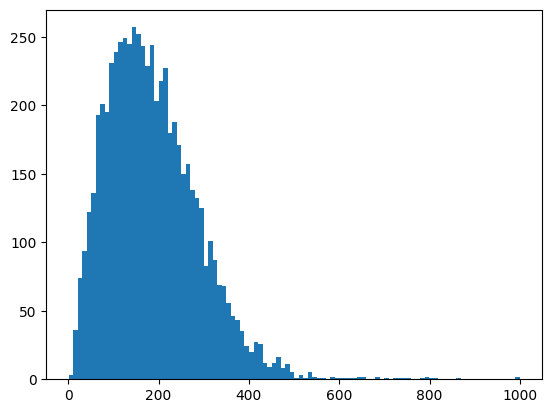

In [5]:
plt.hist(df['kkal'], bins=100)
plt.show()

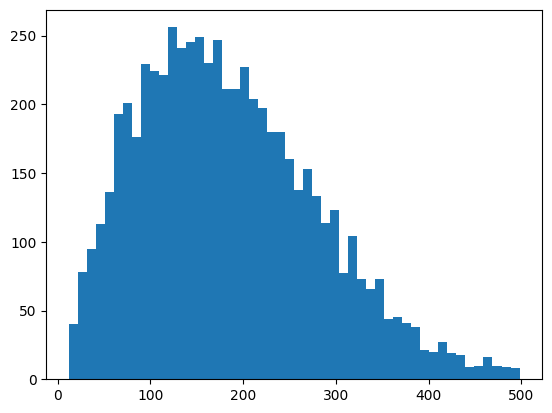

In [6]:
df = df[(df['kkal'] < 500) & (df['kkal'] > 10)]
plt.hist(df['kkal'], bins=50)
plt.show()

In [7]:
X_train, X_tmp, y_train, y_tmp = train_test_split(df['img_path'], df['kkal'], test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

In [8]:
transforms = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

class ImgDataset(Dataset):
    def __init__(self, paths, targets, transforms=None):
        self.paths = paths
        self.targets = targets
        self.transforms = transforms

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        image = decode_image(path)
        target = torch.tensor(self.targets[idx], dtype=torch.float32)

        if self.transforms:
            image = self.transforms(image)
        else:
            image = v2.ToImage()(image)
            image = v2.ToDtype(torch.float32, scale=True)(image)

        return image, target

In [9]:
train_ds = ImgDataset(X_train.values, y_train.values, transforms)
test_ds = ImgDataset(X_test.values, y_test.values)
val_ds = ImgDataset(X_val.values, y_val.values)

dataloaders = {
    'train': DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True),
    'test': DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True),
    'val': DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
}

In [10]:
class CaloriesCNN(nn.Module):
    def __init__(self):
        super().__init__()
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),

                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),

                nn.MaxPool2d(2)
            )

        self.features = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 64),
            conv_block(64, 128),

            nn.AdaptiveAvgPool2d(1)
        )

        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(DROPOUT),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x

    def get_embedding(self, x):
        x = self.features(x)
        x = self.regressor[:-1](x)
        return x

In [11]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda")

model = CaloriesCNN().to(device)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.3,
    patience=3,
)

train_losses = []
val_losses = []
train_mae = []
val_mae = []

for epoch in range(NUM_EPOCHES):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHES}")

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_mae = 0.0
        for images, targets in tqdm(dataloaders[phase]):
            images = images.to(device)
            targets = targets.unsqueeze(1).to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(images)
                loss = criterion(outputs, targets)
                mae = torch.mean(torch.abs(outputs - targets))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * images.size(0)
            running_mae += mae.item() * images.size(0)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_mae = running_mae / len(dataloaders[phase].dataset)

        print(f"{phase} Loss: {epoch_loss:.4f} | MAE: {epoch_mae:.2f} kcal")

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_mae.append(epoch_mae)
        else:
            val_losses.append(epoch_loss)
            val_mae.append(epoch_mae)
            scheduler.step(epoch_loss)


Epoch 1/20


100%|██████████| 68/68 [01:09<00:00,  1.02s/it]


train Loss: 115.5694 | MAE: 116.07 kcal


100%|██████████| 15/15 [00:05<00:00,  3.00it/s]


val Loss: 109.2324 | MAE: 109.73 kcal

Epoch 2/20


100%|██████████| 68/68 [00:47<00:00,  1.44it/s]


train Loss: 76.7652 | MAE: 77.26 kcal


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


val Loss: 71.6855 | MAE: 72.18 kcal

Epoch 3/20


100%|██████████| 68/68 [00:47<00:00,  1.43it/s]


train Loss: 74.5763 | MAE: 75.07 kcal


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


val Loss: 73.5401 | MAE: 74.04 kcal

Epoch 4/20


100%|██████████| 68/68 [00:46<00:00,  1.45it/s]


train Loss: 74.6505 | MAE: 75.15 kcal


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


val Loss: 85.2284 | MAE: 85.73 kcal

Epoch 5/20


100%|██████████| 68/68 [00:46<00:00,  1.45it/s]


train Loss: 74.5105 | MAE: 75.01 kcal


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


val Loss: 71.5618 | MAE: 72.06 kcal

Epoch 6/20


100%|██████████| 68/68 [00:47<00:00,  1.44it/s]


train Loss: 73.9145 | MAE: 74.41 kcal


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


val Loss: 69.9110 | MAE: 70.41 kcal

Epoch 7/20


100%|██████████| 68/68 [00:47<00:00,  1.44it/s]


train Loss: 74.2988 | MAE: 74.80 kcal


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


val Loss: 72.8735 | MAE: 73.37 kcal

Epoch 8/20


100%|██████████| 68/68 [00:47<00:00,  1.45it/s]


train Loss: 73.4332 | MAE: 73.93 kcal


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


val Loss: 70.3978 | MAE: 70.90 kcal

Epoch 9/20


100%|██████████| 68/68 [00:47<00:00,  1.45it/s]


train Loss: 73.8158 | MAE: 74.31 kcal


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


val Loss: 69.0126 | MAE: 69.51 kcal

Epoch 10/20


100%|██████████| 68/68 [00:47<00:00,  1.44it/s]


train Loss: 73.0249 | MAE: 73.52 kcal


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


val Loss: 69.2871 | MAE: 69.79 kcal

Epoch 11/20


100%|██████████| 68/68 [00:47<00:00,  1.45it/s]


train Loss: 73.3020 | MAE: 73.80 kcal


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


val Loss: 75.2926 | MAE: 75.79 kcal

Epoch 12/20


100%|██████████| 68/68 [00:47<00:00,  1.45it/s]


train Loss: 73.2562 | MAE: 73.75 kcal


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


val Loss: 73.6734 | MAE: 74.17 kcal

Epoch 13/20


100%|██████████| 68/68 [00:47<00:00,  1.44it/s]


train Loss: 72.9142 | MAE: 73.41 kcal


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


val Loss: 71.4394 | MAE: 71.94 kcal

Epoch 14/20


100%|██████████| 68/68 [00:47<00:00,  1.44it/s]


train Loss: 72.5904 | MAE: 73.09 kcal


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


val Loss: 68.7835 | MAE: 69.28 kcal

Epoch 15/20


100%|██████████| 68/68 [00:47<00:00,  1.44it/s]


train Loss: 71.3960 | MAE: 71.89 kcal


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


val Loss: 69.2640 | MAE: 69.76 kcal

Epoch 16/20


100%|██████████| 68/68 [00:47<00:00,  1.44it/s]


train Loss: 70.8811 | MAE: 71.38 kcal


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


val Loss: 68.4515 | MAE: 68.95 kcal

Epoch 17/20


100%|██████████| 68/68 [00:47<00:00,  1.44it/s]


train Loss: 71.5849 | MAE: 72.08 kcal


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


val Loss: 69.0962 | MAE: 69.60 kcal

Epoch 18/20


100%|██████████| 68/68 [00:47<00:00,  1.45it/s]


train Loss: 71.0275 | MAE: 71.53 kcal


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


val Loss: 68.1738 | MAE: 68.67 kcal

Epoch 19/20


100%|██████████| 68/68 [00:47<00:00,  1.44it/s]


train Loss: 71.5531 | MAE: 72.05 kcal


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


val Loss: 68.6367 | MAE: 69.13 kcal

Epoch 20/20


100%|██████████| 68/68 [00:47<00:00,  1.44it/s]


train Loss: 70.3227 | MAE: 70.82 kcal


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]

val Loss: 69.9321 | MAE: 70.43 kcal


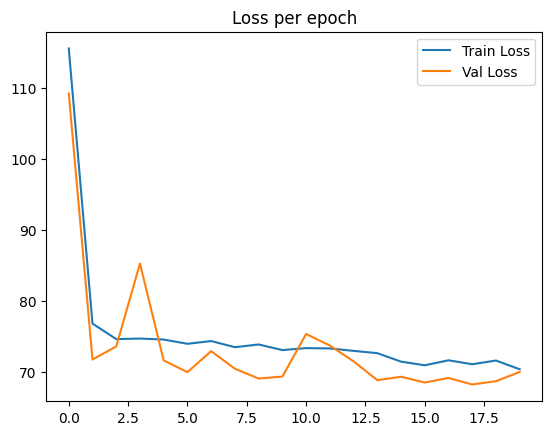

In [12]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss per epoch')
plt.show()


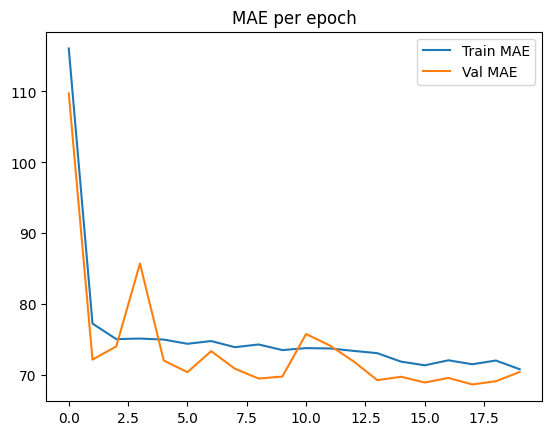

In [13]:
plt.plot(train_mae, label='Train MAE')
plt.plot(val_mae, label='Val MAE')
plt.legend()
plt.title('MAE per epoch')
plt.show()

In [14]:
model.eval()
test_loss = 0.0
test_mae = 0.0

with torch.no_grad():
    for images, targets in dataloaders['test']:
        images = images.to(device)
        targets = targets.unsqueeze(1).to(device)

        outputs = model(images)
        loss = criterion(outputs, targets)
        mae = torch.mean(torch.abs(outputs - targets))

        test_loss += loss.item() * images.size(0)
        test_mae  += mae.item()  * images.size(0)

test_loss /= len(dataloaders['test'].dataset)
test_mae  /= len(dataloaders['test'].dataset)

print(f"TEST Loss: {test_loss:.2f} | TEST MAE: {test_mae:.2f} kcal")


TEST Loss: 69.77 | TEST MAE: 70.27 kcal


# эмбеддинги картинок

In [15]:
embed_ds = ImgDataset(df['img_path'].values, df['kkal'].values)
embed_loader = DataLoader(embed_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

model.eval()
all_embeds = []
all_targets = []

with torch.no_grad():
    for images, targets in embed_loader:
        images = images.to(device)
        emb = model.get_embedding(images)
        all_embeds.append(emb.cpu().numpy())
        all_targets.append(targets.numpy())

all_embeds = np.concatenate(all_embeds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

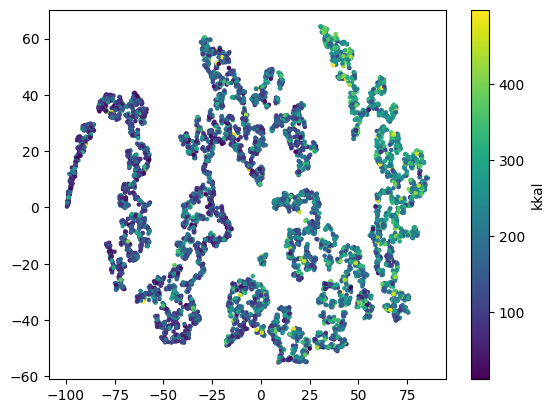

In [16]:
points = TSNE(n_components=2, random_state=42).fit_transform(all_embeds)


plt.scatter(points[:, 0], points[:, 1], c=all_targets, cmap='viridis', s=5)
plt.colorbar(label='kkal')
plt.show()

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


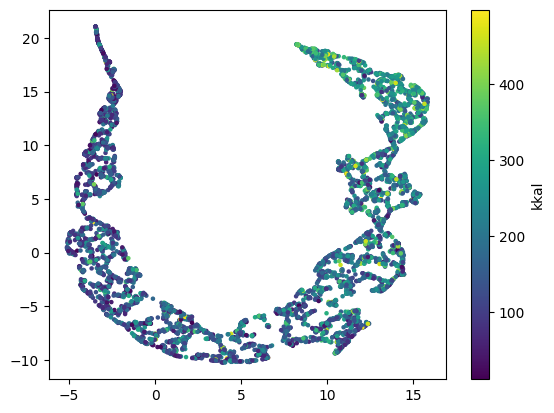

In [18]:
points = umap.UMAP(n_components=2, random_state=42).fit_transform(all_embeds)

plt.scatter(points[:, 0], points[:, 1], c=all_targets, cmap='viridis', s=5)
plt.colorbar(label='kkal')
plt.show()

# transfer learning

In [24]:
train_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])
val_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [25]:
class CaloriesResNet(nn.Module):
    def __init__(self, freeze_backbone: bool = True):
        super().__init__()

        self.backbone = models.resnet18(
            weights=models.ResNet18_Weights.DEFAULT
        )

        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.embedding = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(DROPOUT),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
        )

        self.output = nn.Linear(64, 1)

        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

    def forward(self, x):
        x = self.backbone(x)
        x = self.embedding(x)
        x = self.output(x)
        return x

    def get_embedding(self, x):
        x = self.backbone(x)
        x = self.embedding(x)
        return x

In [30]:
train_ds = ImgDataset(X_train.values, y_train.values, train_transforms)
test_ds = ImgDataset(X_test.values, y_test.values, val_transforms)
val_ds = ImgDataset(X_val.values, y_val.values, val_transforms)

dataloaders = {
    'train': DataLoader(train_ds, batch_size=512, shuffle=True, num_workers=2, pin_memory=True),
    'test': DataLoader(test_ds, batch_size=512, shuffle=False, num_workers=2, pin_memory=True),
    'val': DataLoader(val_ds, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)
}

In [31]:
model = CaloriesResNet(freeze_backbone=True).to(device)

criterion = nn.SmoothL1Loss()
head_params = list(model.embedding.parameters()) + list(model.output.parameters())

optimizer = torch.optim.Adam(
    head_params,
    lr=1e-3,
    weight_decay=1e-4,
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.3,
    patience=3,
)

train_losses = []
val_losses = []
train_mae = []
val_mae = []

for epoch in range(NUM_EPOCHES):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHES}")

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_mae = 0.0

        for images, targets in tqdm(dataloaders[phase]):
            images = images.to(device)
            targets = targets.unsqueeze(1).to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(images)
                loss = criterion(outputs, targets)
                mae = torch.mean(torch.abs(outputs - targets))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * images.size(0)
            running_mae += mae.item() * images.size(0)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_mae = running_mae / len(dataloaders[phase].dataset)

        print(f"{phase} Loss: {epoch_loss:.4f} | MAE: {epoch_mae:.2f} kcal")

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_mae.append(epoch_mae)
        else:
            val_losses.append(epoch_loss)
            val_mae.append(epoch_mae)
            scheduler.step(epoch_loss)


Epoch 1/20


100%|██████████| 9/9 [00:24<00:00,  2.72s/it]


train Loss: 182.2270 | MAE: 182.73 kcal


100%|██████████| 2/2 [00:08<00:00,  4.48s/it]


val Loss: 176.6432 | MAE: 177.14 kcal

Epoch 2/20


100%|██████████| 9/9 [00:12<00:00,  1.43s/it]


train Loss: 168.7031 | MAE: 169.20 kcal


100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


val Loss: 153.1838 | MAE: 153.68 kcal

Epoch 3/20


100%|██████████| 9/9 [00:12<00:00,  1.39s/it]


train Loss: 136.3753 | MAE: 136.87 kcal


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


val Loss: 109.7177 | MAE: 110.22 kcal

Epoch 4/20


100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


train Loss: 92.9079 | MAE: 93.41 kcal


100%|██████████| 2/2 [00:03<00:00,  1.81s/it]


val Loss: 77.7469 | MAE: 78.25 kcal

Epoch 5/20


100%|██████████| 9/9 [00:13<00:00,  1.45s/it]


train Loss: 81.7585 | MAE: 82.26 kcal


100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


val Loss: 82.2333 | MAE: 82.73 kcal

Epoch 6/20


100%|██████████| 9/9 [00:13<00:00,  1.55s/it]


train Loss: 81.0484 | MAE: 81.55 kcal


100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


val Loss: 77.0314 | MAE: 77.53 kcal

Epoch 7/20


100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


train Loss: 78.4298 | MAE: 78.93 kcal


100%|██████████| 2/2 [00:04<00:00,  2.03s/it]


val Loss: 77.5810 | MAE: 78.08 kcal

Epoch 8/20


100%|██████████| 9/9 [00:11<00:00,  1.31s/it]


train Loss: 77.6565 | MAE: 78.16 kcal


100%|██████████| 2/2 [00:04<00:00,  2.14s/it]


val Loss: 76.0541 | MAE: 76.55 kcal

Epoch 9/20


100%|██████████| 9/9 [00:14<00:00,  1.65s/it]


train Loss: 76.9368 | MAE: 77.44 kcal


100%|██████████| 2/2 [00:04<00:00,  2.44s/it]


val Loss: 75.5047 | MAE: 76.00 kcal

Epoch 10/20


100%|██████████| 9/9 [00:15<00:00,  1.69s/it]


train Loss: 76.7132 | MAE: 77.21 kcal


100%|██████████| 2/2 [00:03<00:00,  1.88s/it]


val Loss: 74.9304 | MAE: 75.43 kcal

Epoch 11/20


100%|██████████| 9/9 [00:12<00:00,  1.39s/it]


train Loss: 75.7213 | MAE: 76.22 kcal


100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


val Loss: 74.4090 | MAE: 74.91 kcal

Epoch 12/20


100%|██████████| 9/9 [00:16<00:00,  1.78s/it]


train Loss: 75.2880 | MAE: 75.79 kcal


100%|██████████| 2/2 [00:04<00:00,  2.16s/it]


val Loss: 73.7861 | MAE: 74.29 kcal

Epoch 13/20


100%|██████████| 9/9 [00:13<00:00,  1.45s/it]


train Loss: 74.1756 | MAE: 74.67 kcal


100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


val Loss: 73.2241 | MAE: 73.72 kcal

Epoch 14/20


100%|██████████| 9/9 [00:13<00:00,  1.46s/it]


train Loss: 73.8660 | MAE: 74.36 kcal


100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


val Loss: 72.5822 | MAE: 73.08 kcal

Epoch 15/20


100%|██████████| 9/9 [00:12<00:00,  1.38s/it]


train Loss: 73.4215 | MAE: 73.92 kcal


100%|██████████| 2/2 [00:05<00:00,  2.73s/it]


val Loss: 71.9969 | MAE: 72.50 kcal

Epoch 16/20


100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


train Loss: 72.4213 | MAE: 72.92 kcal


100%|██████████| 2/2 [00:03<00:00,  1.66s/it]


val Loss: 71.3287 | MAE: 71.83 kcal

Epoch 17/20


100%|██████████| 9/9 [00:13<00:00,  1.45s/it]


train Loss: 71.7974 | MAE: 72.30 kcal


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


val Loss: 70.6941 | MAE: 71.19 kcal

Epoch 18/20


100%|██████████| 9/9 [00:12<00:00,  1.42s/it]


train Loss: 71.2802 | MAE: 71.78 kcal


100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


val Loss: 70.0771 | MAE: 70.58 kcal

Epoch 19/20


100%|██████████| 9/9 [00:13<00:00,  1.48s/it]


train Loss: 70.5254 | MAE: 71.02 kcal


100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


val Loss: 69.3859 | MAE: 69.88 kcal

Epoch 20/20


100%|██████████| 9/9 [00:12<00:00,  1.42s/it]


train Loss: 69.8974 | MAE: 70.40 kcal


100%|██████████| 2/2 [00:03<00:00,  1.77s/it]

val Loss: 68.6586 | MAE: 69.16 kcal


тут решил попробовать еще 10 эпох прогнать

In [32]:
for epoch in range(19, 30):
    print(f"\nEpoch {epoch+1}/{30}")

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_mae = 0.0

        for images, targets in tqdm(dataloaders[phase]):
            images = images.to(device)
            targets = targets.unsqueeze(1).to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(images)
                loss = criterion(outputs, targets)
                mae = torch.mean(torch.abs(outputs - targets))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * images.size(0)
            running_mae += mae.item() * images.size(0)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_mae = running_mae / len(dataloaders[phase].dataset)

        print(f"{phase} Loss: {epoch_loss:.4f} | MAE: {epoch_mae:.2f} kcal")

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_mae.append(epoch_mae)
        else:
            val_losses.append(epoch_loss)
            val_mae.append(epoch_mae)
            scheduler.step(epoch_loss)


Epoch 20/30


100%|██████████| 9/9 [00:13<00:00,  1.54s/it]


train Loss: 68.7759 | MAE: 69.27 kcal


100%|██████████| 2/2 [00:03<00:00,  1.94s/it]


val Loss: 67.9956 | MAE: 68.49 kcal

Epoch 21/30


100%|██████████| 9/9 [00:13<00:00,  1.51s/it]


train Loss: 68.3235 | MAE: 68.82 kcal


100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


val Loss: 67.4139 | MAE: 67.91 kcal

Epoch 22/30


100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


train Loss: 67.2908 | MAE: 67.79 kcal


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


val Loss: 66.6838 | MAE: 67.18 kcal

Epoch 23/30


100%|██████████| 9/9 [00:14<00:00,  1.59s/it]


train Loss: 66.7546 | MAE: 67.25 kcal


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


val Loss: 66.1266 | MAE: 66.63 kcal

Epoch 24/30


100%|██████████| 9/9 [00:14<00:00,  1.62s/it]


train Loss: 66.6942 | MAE: 67.19 kcal


100%|██████████| 2/2 [00:04<00:00,  2.08s/it]


val Loss: 65.7481 | MAE: 66.24 kcal

Epoch 25/30


100%|██████████| 9/9 [00:12<00:00,  1.36s/it]


train Loss: 65.8709 | MAE: 66.37 kcal


100%|██████████| 2/2 [00:04<00:00,  2.28s/it]


val Loss: 65.3866 | MAE: 65.89 kcal

Epoch 26/30


100%|██████████| 9/9 [00:12<00:00,  1.39s/it]


train Loss: 65.2891 | MAE: 65.79 kcal


100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


val Loss: 65.1090 | MAE: 65.61 kcal

Epoch 27/30


100%|██████████| 9/9 [00:13<00:00,  1.55s/it]


train Loss: 64.7237 | MAE: 65.22 kcal


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


val Loss: 64.8831 | MAE: 65.38 kcal

Epoch 28/30


100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


train Loss: 64.7004 | MAE: 65.20 kcal


100%|██████████| 2/2 [00:04<00:00,  2.13s/it]


val Loss: 64.6745 | MAE: 65.17 kcal

Epoch 29/30


100%|██████████| 9/9 [00:17<00:00,  1.90s/it]


train Loss: 64.4372 | MAE: 64.94 kcal


100%|██████████| 2/2 [00:05<00:00,  2.78s/it]


val Loss: 64.5435 | MAE: 65.04 kcal

Epoch 30/30


100%|██████████| 9/9 [00:25<00:00,  2.81s/it]


train Loss: 64.4248 | MAE: 64.92 kcal


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]

val Loss: 64.4036 | MAE: 64.90 kcal


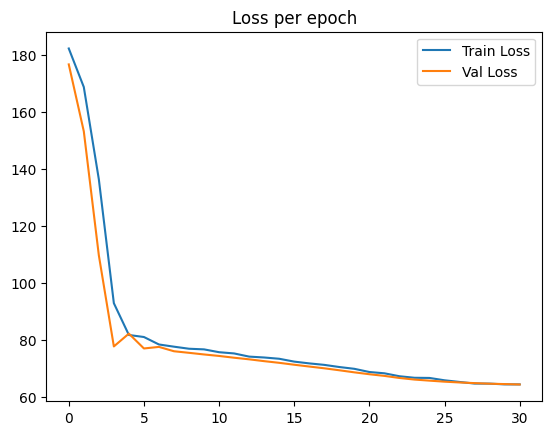

In [33]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss per epoch')
plt.show()


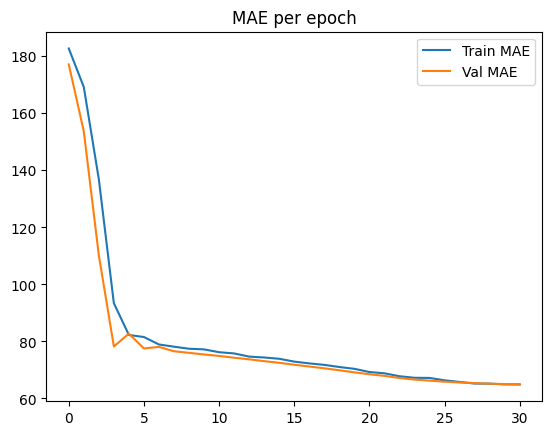

In [34]:
plt.plot(train_mae, label='Train MAE')
plt.plot(val_mae, label='Val MAE')
plt.legend()
plt.title('MAE per epoch')
plt.show()

In [35]:
model.eval()
test_loss = 0.0
test_mae = 0.0

with torch.no_grad():
    for images, targets in dataloaders['test']:
        images = images.to(device)
        targets = targets.unsqueeze(1).to(device)

        outputs = model(images)
        loss = criterion(outputs, targets)
        mae = torch.mean(torch.abs(outputs - targets))

        test_loss += loss.item() * images.size(0)
        test_mae  += mae.item()  * images.size(0)

test_loss /= len(dataloaders['test'].dataset)
test_mae  /= len(dataloaders['test'].dataset)

print(f"TEST Loss: {test_loss:.2f} | TEST MAE: {test_mae:.2f} kcal")

TEST Loss: 63.20 | TEST MAE: 63.70 kcal


# Сравнение моделей
моя:
- train MAE(20 эпох) = 70.82 kcal
- test MAE(20 эпох) =  70.27 kcal

ResNet:
- train MAE(20 эпох) = 69.16 kcal
- train MAE(30 эпох) = 64.90 kcal
- test MAE(30 эпох) =  63.70 kcal

## также модель ResNet обучается намного быстрее т.к. можно задать размер батча больше